# Determining Optimal Food Truck Locations
_Evaluating Neighborhoods in Austin, Texas_

The audience for this data science problem will be owners and operators of traveling food trucks. As food truck operators enter a new city and a new market, a persistent question will be: where to park the foodtruck for maximum revenue. We will attempt to use data science and data from Foursquare to allow foodtruck operators to make a data-informed decision about where to park their food truck.

In this project we will determine the optimal Austin neighborhood to park a new food truck in. We will understand each Austin neighborhood's proximity to popular nightlife spots, as well as how saturated the food truck market is in the given neighborhood.

### Import Required Libraries and Set Global Variables

In [13]:
from sklearn import metrics, preprocessing
from geopy.geocoders import Nominatim
from IPython.display import display
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import pandas as pd
import numpy as np
import requests
import folium
import random

mpl.style.use('seaborn-muted')
client_id = 'GGIL3FS30MVYZXY0LH1243H5A2QNHDGQJD2P3YHH1ELMLLVP'
client_secret = 'WHZXQ1O5I351N0VLZUG4GYNC53F4N3RWFSR3JYK2LKL2XV24'
version = '20201120'  # Date this code was developed

## Get List of Austin Neighborhoods
I manually compiled a list of Austin Neighborhoods at [this link](https://raw.githubusercontent.com/bryandeagle/Coursera_Capstone/main/austin.csv). This is a CSV file containing neighborhoods with longitudes and latitudes. It was compiled from the Wikipedia page [Category:Neighborhoods in Austin, Texas](https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Austin,_Texas).

In [11]:
df = pd.read_csv('https://github.com/bryandeagle/Coursera_Capstone/raw/main/data/austin.csv')
df.head()

,Neighborhood,Latitude,Longitude
0,Allandale,30.342000,-97.744000
1,Anderson Mill,30.455000,-97.809167
2,Barton Hills,30.258056,-97.781111
3,Blackland,30.280991,-97.722097
4,Bouldin Creek,30.249344,-97.755253


## Get Proximity to Nightlife and Food Trucks

The *venue_count* function below uses the Foursquare API to get a count of venues with 1 km radius of a given location. It will be used to find the counts of nightlife spots and food trucks.

I've also created a dummy function which returns random data to help me debug without running through my Foursquare API call quota.

The Foursquare categories I'm using are below. Food truck consists of a single category, while nightlife consisters of a large set of categories. Those categories are: Beach Bar, Beer Bar, Beer Garden, Champagne Bar, Cocktail bar, Dive Bar, Gay Bar, Hookah Bar, Karaoke Bar, Pub, Sake Bar, Speakeasy, Tiki Bar, Whisky Bar, Wine Bar, Brewery, Lounge, Nightclub, and Other Nightlife.

In [3]:
# Foursquare categories
foodtruck = '4bf58dd8d48988d1cb941735'
nightlife = '52e81612bcbc57f1066b7a0d,56aa371ce4b08b9a8d57356c,4bf58dd8d48988d117941735,52e81612bcbc57f1066b7a0e,4bf58dd8d48988d11e941735,4bf58dd8d48988d118941735,4bf58dd8d48988d1d8941735,4bf58dd8d48988d119941735,4bf58dd8d48988d120941735,4bf58dd8d48988d11b941735,4bf58dd8d48988d11c941735,4bf58dd8d48988d1d4941735,56aa371be4b08b9a8d57354d,4bf58dd8d48988d122941735,4bf58dd8d48988d123941735,50327c8591d4c4b30a586d5d,4bf58dd8d48988d121941735,4bf58dd8d48988d11f941735,4bf58dd8d48988d11a941735'

In [4]:
def venue_count_dummy(row, category):
    """ Dummy of venue count to avoid exceeding quota during debug """
    return random.randint(0, 50)

def venue_count(row, category):
    """ Returns count of venues within a 1 km radius of a location """
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}' \
          '&v={}&categoryId={}&radius=1000&limit=50'.format(client_id, client_secret, row[0], row[1], \
                                                            version, category)
    results = requests.get(url).json()
    if results['meta']['code'] == '429':
        raise ValueError('Foursquare Quota Exceeded')
    return int(results['response']['totalResults'])

### Adding Nightlife and Food Truck Columns to Data Frame

Here I create my new columns using the function defined above. I get a nightlife count for each neighborhood, I drop neighborhoods with less than 5 nightlife spots, and then I add food truck information. This helps minimize API calls.

In [14]:
# Get nighlife venue count and add to dataframe
df['Nightlife'] = df[['Latitude', 'Longitude']].apply(venue_count, args=(nightlife,), axis=1)

# Drop neighborhoods with to few nightlife spots
df.drop(df[df['Nightlife'] < 5 ].index, inplace=True)

# Get food truck venue count and add to dataframe
df['Food Truck'] = df[['Latitude', 'Longitude']].apply(venue_count, args=(foodtruck,), axis=1)

# Calculate and sort byFoodtruck-to-Bar Ratio (FBR)
df['FNR'] = df['Food Truck'] / df['Nightlife']
df.sort_values('FNR', inplace=True)
display(df)  # Display results

,Neighborhood,Latitude,Longitude,Nightlife,Food Truck,FNR
27,North Shoal Creek,30.365300,-97.733500,8,3,0.375000
12,Clarksville,30.280833,-97.762222,5,2,0.400000
33,Saint John,30.330000,-97.698000,6,3,0.500000
5,Bremond Block,30.270556,-97.746389,158,117,0.740506
15,Downtown Austin,30.271000,-97.743000,169,130,0.769231
25,Mueller Community,30.289444,-97.702636,7,6,0.857143
13,Congress Avenue,30.267778,-97.742500,182,163,0.895604
48,Zilker,30.250000,-97.766667,15,16,1.066667
41,Travis Heights,30.241667,-97.741667,5,7,1.400000
31,Rainey Street,30.259444,-97.738333,120,177,1.475000


### Plot Neighborhoods with Lowest Foodtruck-to-Nightlife Ratio

Now we'll make a nice bar chart showing neighborhoods and their foodtruck-to-nightlife ratio. Although not required for finding the minimum, it helps us understand how many similar neighborhoods there are. As you can see Clarksville is in a similar position to North Shoal Creek.

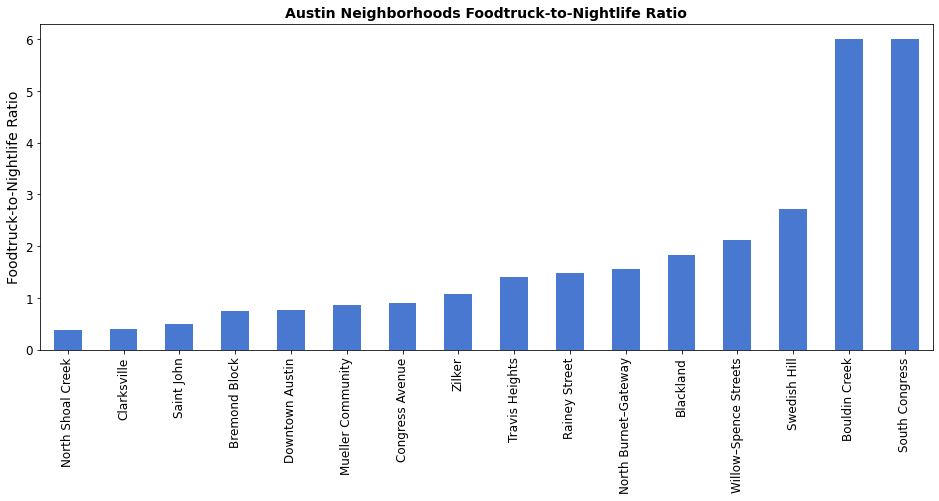

In [6]:
# Plot neighborhoods in descendingn order by BFR
df.plot(kind='bar',
        x='Neighborhood', y='FNR', xlabel='',
        figsize=(16, 6), fontsize=12, legend=None)
plt.title('Austin Neighborhoods Foodtruck-to-Nightlife Ratio', fontsize=14, fontweight='bold')
plt.ylabel('Foodtruck-to-Nightlife Ratio', fontsize=14)
plt.show()

## Select the Best Neighborhood
Here we'll grab the neighborhood with the minimal Foodtruck-to-Nighlife ratio and convert to a dictionary for easy manipulation.

In [7]:
# Get row(s) with minimal foodtruck-to-nightlife ratio
nbh_df = df[df['FNR'] == df['FNR'].min()]

# Convert dataframe to dictionary
nbh_dict = nbh_df.to_dict('records')[0]

print('Best Neighborhood: {}!'.format(nbh_dict['Neighborhood']))

Best Neighborhood: North Shoal Creek!


## Get Venues in Neighborhood
Now we'll use the Foursquare API to get a list of nightlife spots in the neighborhood, with the end goal of determining where in this neighborhood to park our food truck.

In [8]:
def venues(latitude, longitude, category):
    """ Returns venues within a 1 km radius of a location """
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}' \
          '&v={}&categoryId={}&radius=1000&limit=50'.format(client_id, client_secret, latitude, \
                                                            longitude, version, category)
    results = requests.get(url).json()
    if results['meta']['code'] == '429':
        raise ValueError('Foursquare Quota Exceeded')
    return pd.json_normalize(results['response']['groups'][0]['items'])

df_nl = venues(nbh_dict['Latitude'], nbh_dict['Longitude'], nightlife)
df_nl = df_nl[['venue.name', 'venue.location.lat', 'venue.location.lng']]
df_nl.columns = ['Venue', 'Latitude', 'Longitude']
df_nl.head()

,Venue,Latitude,Longitude
0,The Common Interest Karaoke Bar & Grill,30.366192,-97.729144
1,Slick Willie's Family Pool,30.366677,-97.729049
2,Water 2 Wine,30.362011,-97.742086
3,Nosh & Bevvy,30.365414,-97.728802
4,Buddy's,30.368978,-97.727205


## Find Clusters of Nightlife Spots Within Neighborhood
Here we'll use the DBSCAN of clustering to cluster nightlife spots. We know there will be loner bars, not clumped together and we want to be able to exclude those as noise, so DBSCAN will be a good method of clustering in this application.

In [9]:
mms = preprocessing.MinMaxScaler()
lat_lng = mms.fit_transform(df_nl[['Latitude', 'Longitude']])
db = DBSCAN(eps=0.5, min_samples=3).fit(lat_lng)

labels = db.labels_
unique_labels = set(labels)

# Add labels as column in dataframe
df_nl['Label'] = labels

# Get the biggest cluster of nightlife spots
cluster = stats.mode(labels[labels >= 0])[0][0]

# Parking spot should be average of nightlife spots
df_c = df_nl[df_nl['Label'] == cluster]
prk_lat, prk_lng = df_c['Latitude'].mean(), df_c['Longitude'].mean()

print('Best Parking Location: ({}, {}).'.format(prk_lat, prk_lng))

Best Parking Location: (30.367016031794574, -97.72840703272023).


## Create Map of Clusters
Now we'll use Folium to creat a map of our neighborhood, and highlight the clusters. We'll create a red point representing the center of the neighborhood, and a green point representing the best parking location. Black dots will represent *noise* and the clusters will be randomly colored.

In [15]:
# Creat map object
venues_map = folium.Map(location=[nbh_dict['Latitude'], nbh_dict['Longitude']], zoom_start=14)

# Add neighborhood center as red circle marker
folium.CircleMarker(
        [nbh_dict['Latitude'], nbh_dict['Longitude']],
        radius=4,
        popup=nbh_dict['Neighborhood'],
        fill=True,
        color='red',
        fill_color='red',
        fill_opacity=1.0
    ).add_to(venues_map)

# Create colors for unique labels
def rand_color():
    return "#%06x" % random.randrange(0, 16**6)

colors = [rand_color()] * len(unique_labels)

# add the nightlife spots as blue circle markers
for lat, lng, name, label in zip(df_nl['Latitude'], df_nl['Longitude'], df_nl['Venue'], labels):    
    col = colors[label] if label >= 0 else 'black'
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=name,
        fill=True,
        color=col,
        fill_color=col,
        fill_opacity=1.0
    ).add_to(venues_map)

# Add parking spot as white circle marker
folium.CircleMarker(
        [prk_lat, prk_lng],
        radius=4,
        popup='Best Parking Spot',
        fill=True,
        color='green',
        fill_color='green',
        fill_opacity=1.0
    ).add_to(venues_map)

venues_map

## Get Address of Ideal Food Truck Parking Spot
Now we'll use geopy to get the address of our parking spot, which would be the final deliverable for our foodtruck driver.

In [ ]:
parking_spot = Nominatim(user_agent='explore').reverse((prk_lat, prk_lng)).raw
print('Ideal Parking Spot: {}.'.format(parking_spot['display_name']))